<a href="https://colab.research.google.com/github/trunghn2003/Deep-Learning-Based-Intrusion-Detection-NSL-KDD/blob/master/Final%20Artefact.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTING THE REQUIRED LIBRARIES

In [2]:
#Make sure all the following libraries are installed before running the application.
import pandas as pd
import numpy as np
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings

from keras.preprocessing import sequence
from keras import optimizers
# from keras.utils import np_utils # This import is causing the error
from tensorflow.keras.utils import to_categorical # Use to_categorical from tensorflow.keras.utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, SimpleRNN, BatchNormalization
from keras.models import model_from_json

warnings.filterwarnings("ignore")
%matplotlib inline

## LOADING TRAINING AND TESTING DATA

In [3]:
#load the csv file containing the column names
column_name = pd.read_csv("Field Names.csv", header = None)

In [4]:
#Convert the array into list
new_columns = list(column_name[0].values)

In [5]:
#adding difficulty
new_columns += ['class', 'difficulty']

In [6]:
#loading train and test data files
train_data = pd.read_csv('KDDTrain+.txt', names = new_columns)
test_data = pd.read_csv('KDDTest+.txt', names = new_columns)

In [7]:
#Training data sample
print("The training data is")
train_data.tail()

The training data is


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.0,0.00,0.0,0.00,0.0,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.0,0.72,0.0,0.01,0.0,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.0,1.00,1.0,0.00,0.0,neptune,20
125972,0,tcp,ftp_data,SF,151,0,0,0,0,0,...,0.30,0.03,0.30,0.0,0.00,0.0,0.00,0.0,normal,21


In [8]:
#Output total rows and columns of dataframe
print(f"The shape of the training dataframe is : {train_data.shape}")

The shape of the training dataframe is : (125973, 43)


In [9]:
#Same for testing
print("The testing data is")
test_data.head()

The testing data is


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [10]:
#Idem dito ^
print(f"The shape of the testing dataframe is : {test_data.shape}")

The shape of the testing dataframe is : (22544, 43)


In [11]:
#Load attacks.txt containing the attack categories
map_attacks = [x.strip().split() for x in open('attacks.txt', 'r')]
map_attacks = {k:v for (k,v) in map_attacks}

In [12]:
#Replace the "class" column values to 5 attack categories in training and testing dataframe
train_data['class'] = train_data['class'].replace(map_attacks)
test_data['class'] = test_data['class'].replace(map_attacks)

In [13]:
train_data = shuffle(train_data)

## DATA PREPROCESSING

In [14]:
#separate the training dataframe into feature columns and label columns
X = train_data.drop('class', axis = 1) #Independent features
y = train_data['class'] #Dependent features (Labels)

In [15]:
#Converting String to Integer with get_dummies by pandas
columns = ['protocol_type', 'service', 'flag']
X_new = pd.get_dummies(X, columns = columns, drop_first = True)

In [16]:
#Idem dito for class ^
y_new = train_data['class']
y_new = pd.get_dummies(y_new)

In [17]:
#Split data: 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2, random_state = 101)

In [18]:
#Use StandardScaler() to standardize data - explained in Honours Project
sc = StandardScaler()
sc.fit(np.array(X_train))
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

MODEL 1:

First model. This model contains all the dense layers. In dense layers each node or neuron in a layer is connected to all the nodes/neurons in the preceding layer, further explained in Honours Document.

In [19]:
#Use the keras's sequential API
#First dense layer takes an input parameter as 256 (number of neurons in the first layer).
#The second parameter "input_dim" corresponds to the input features.
#Use "relu" as activation function.
#The activation function for last dense layer is "softmax" because of the multiple classes, further explained in document.
#Set dropout for 10%.
model1 = Sequential()
model1.add(Dense(64, input_dim = 120, activation = "relu", kernel_initializer = "lecun_normal"))
model1.add(Dense(128, activation = "relu"))
model1.add(Dense(5, activation = "softmax"))

In [20]:
#Summary of model architecture listing information about parameters per layer.
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         7,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,709 (65.27 KB)

 Trainable params: 16,709 (65.27 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
#Three paramaters:
#Loss - The loss function.
#Optimizer - To minimize the loss function.
#Metrics - The mode of evaluation for our model.
#"categorical_loss" - is used because of the multi-class classifcation problem.
#"adam" - The updated version of SGD.
optim = optimizers.SGD(learning_rate = 0.0001)
model1.compile(loss = 'categorical_crossentropy', optimizer = optim, metrics = ['accuracy'])

In [22]:
#Fit the model on our data.
#X_train - The feature columns of the training data.
#y_train - The labels columns of the training data.
#validation_data - The validation data
#batch_size and epochs further explained in document.
history = model1.fit(X_train, y_train,
          validation_data = (X_test, y_test),
          batch_size = 32,
          epochs = 20)

Epoch 1/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.4060 - loss: 1.4373 - val_accuracy: 0.8154 - val_loss: 0.9204
Epoch 2/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8370 - loss: 0.8315 - val_accuracy: 0.8752 - val_loss: 0.5995
Epoch 3/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8741 - loss: 0.5575 - val_accuracy: 0.8943 - val_loss: 0.4444
Epoch 4/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8943 - loss: 0.4250 - val_accuracy: 0.9151 - val_loss: 0.3596
Epoch 5/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9125 - loss: 0.3474 - val_accuracy: 0.9315 - val_loss: 0.3061
Epoch 6/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9317 - loss: 0.2994 - val_accuracy: 0.9444 - val_loss: 0.2688
Epoch 7/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9432 - loss: 0.2614 - val_accuracy: 0.9508 - val_loss: 0.2410
Epoch 8/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9497 - loss: 0.2

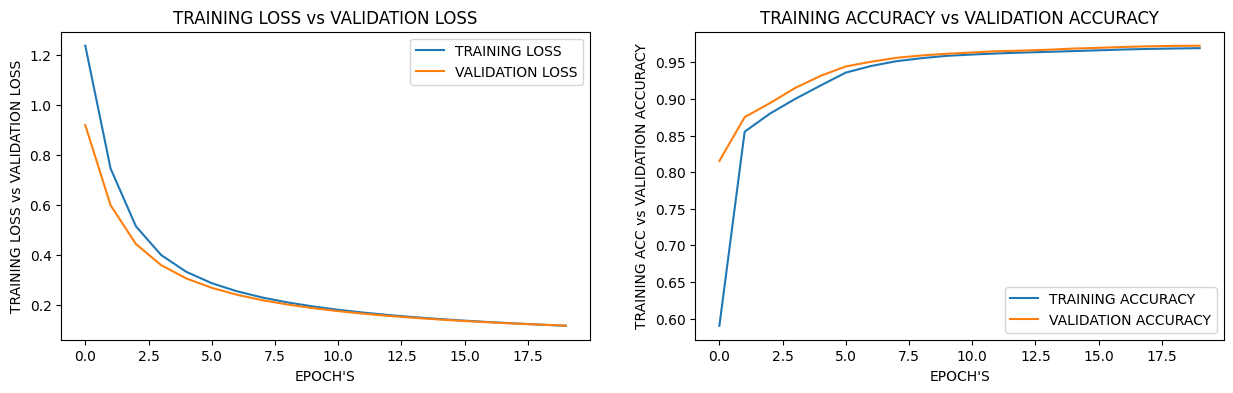

In [23]:
#use matplitlib to draw the plots
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = "TRAINING LOSS")
plt.plot(history.history['val_loss'], label = "VALIDATION LOSS")
plt.title("TRAINING LOSS vs VALIDATION LOSS")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING LOSS vs VALIDATION LOSS")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = "TRAINING ACCURACY")
plt.plot(history.history['val_accuracy'], label = "VALIDATION ACCURACY")
plt.title("TRAINING ACCURACY vs VALIDATION ACCURACY")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING ACC vs VALIDATION ACCURACY")
plt.legend(loc = "best")

Explained in Results section.

Load and save model 1:

In [24]:
#Serialize model 1 , save with json.
model_json = model1.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)
model1.save_weights('model1.weights.h5')
print("Saved model to disk")

Saved model to disk


In [25]:
# load model 1.
json_file = open("model1.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model1.weights.h5")
print("Loaded model from disk")

Loaded model from disk


Model 2:

Single Dense Hidden Layer with Output Layer

In [26]:
model2 = Sequential()
model2.add(Dense(32, input_dim = 120, activation = "relu", kernel_initializer = "lecun_normal"))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(5, activation = "softmax"))

In [27]:
#List summary again
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │         3,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,221 (20.39 KB)

 Trainable params: 5,157 (20.14 KB)

 Non-trainable params: 64 (256.00 B)

In [28]:
#SGD used instead of Adam!
optim2 = optimizers.Adam(learning_rate = 0.0001)
model2.compile(loss = 'categorical_crossentropy', optimizer = optim2, metrics = ['accuracy'])

In [29]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model1, "out/")

failed to lookup keras version from the file,
    this is likely a weight only file


In [30]:
import tensorflow as tf

# Đặt dòng này TRƯỚC khi build/compile model2
tf.config.run_functions_eagerly(True)

# (Tuỳ chọn) Ép dtype để tránh lệch kiểu
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test  = tf.convert_to_tensor(X_test,  dtype=tf.float32)
y_test  = tf.convert_to_tensor(y_test,  dtype=tf.float32)

history2 = model2.fit(
    X_train, y_train,
    batch_size=32,
    epochs=30,
    validation_data=(X_test, y_test),
    verbose=1,
)


Epoch 1/30
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 274s 87ms/step - accuracy: 0.7654 - loss: 0.7445 - val_accuracy: 0.9781 - val_loss: 0.1000
Epoch 2/30
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 319s 86ms/step - accuracy: 0.9724 - loss: 0.0898 - val_accuracy: 0.9909 - val_loss: 0.0745
Epoch 3/30
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 265s 84ms/step - accuracy: 0.9837 - loss: 0.0547 - val_accuracy: 0.9927 - val_loss: 0.0732
Epoch 4/30
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 264s 84ms/step - accuracy: 0.9878 - loss: 0.0399 - val_accuracy: 0.9933 - val_loss: 0.0616
Epoch 5/30
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 268s 85ms/step - accuracy: 0.9900 - loss: 0.0324 - val_accuracy: 0.9938 - val_loss: 0.0492
Epoch 6/30
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 323s 85ms/step - accuracy: 0.9909 - loss: 0.0304 - val_accuracy: 0.9950 - val_loss: 0.0572
Epoch 7/30
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 325s 86ms/step - accuracy: 0.9918 - loss: 0.0266 - val_accuracy: 0.9951 - val_loss: 0.0508
Epoch 8/30
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 267s 85ms/step - accuracy: 

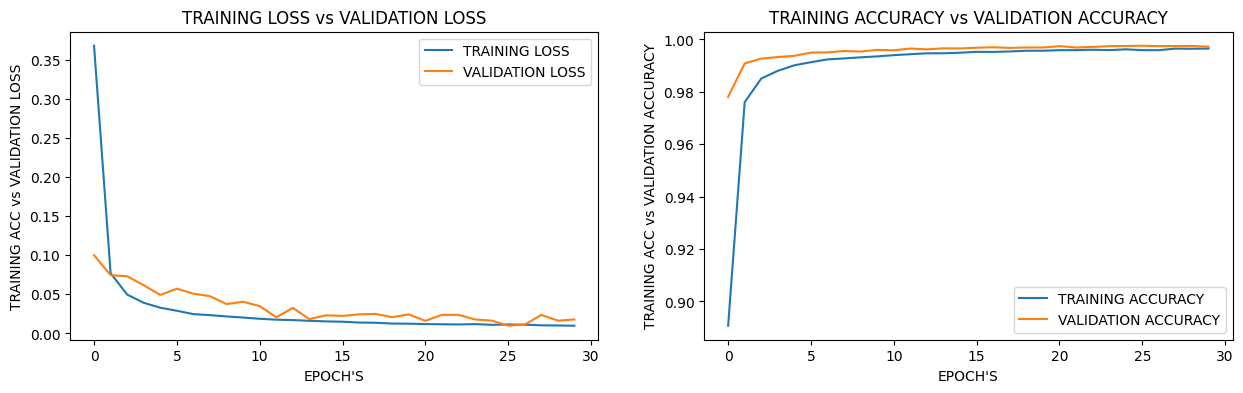

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label = "TRAINING LOSS")
plt.plot(history2.history['val_loss'], label = "VALIDATION LOSS")
plt.title("TRAINING LOSS vs VALIDATION LOSS")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING ACC vs VALIDATION LOSS")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label = "TRAINING ACCURACY")
plt.plot(history2.history['val_accuracy'], label = "VALIDATION ACCURACY")
plt.title("TRAINING ACCURACY vs VALIDATION ACCURACY")
plt.xlabel("EPOCH'S")
plt.ylabel("TRAINING ACC vs VALIDATION ACCURACY")
plt.legend(loc = "best")

Explained in results section.

In [32]:
import tensorflow as tf

# Enable eager execution
tf.compat.v1.enable_eager_execution()

In [33]:
!pip install tensorflowjs